In [1]:
!pip install dipy
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 951.5 kB/s eta 0:00:00


In [2]:
import os
from google.colab import drive
mount_path = '/content/drive'
drive_path = mount_path+"/MyDrive/dti-transformer/code/model"
results_path = drive_path+"/results"
test_data = mount_path+'/MyDrive/dti-transformer/dti_data'
drive.mount(mount_path)
os.chdir(drive_path)

Mounted at /content/drive


In [3]:
# Daniel Bandala @ nov-2022
# dti-model validation script
# general libraries
import csv, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log10, sqrt
# diffussion image processing
from dipy.io.image import load_nifti
# import torch libraries
import torch
from torch import nn
# import dataset auxiliar libraries
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from dti_model import DiffusionTensorModel
from unet_model import DiffusionTensorModelUNet
from other.unet import UNet
from data_loader import data_preprocessing, normalize_data
from torchvision.transforms import functional as TF

In [4]:
# set plot parameters
plt.rcParams.update({'font.size': 20})

In [23]:
signals = 7
maps = ["RGB"] #"MD","MO","L1","L2","L3",FA

In [31]:
# load model
checkpoint = torch.load(results_path+'/dti_fa.weights') #dti_fa.weights FA_2023-03-30
model_fa = DiffusionTensorModel(
    in_chans=signals,
    out_chans=1,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=False
)
# use model in cpu for validation (gpu for training)
_ = model_fa.to('cpu')
_ = model_fa.load_state_dict(checkpoint) #torch.load(, map_location=torch.device('cpu'))
_ = model_fa.eval()

In [32]:
# load model
checkpoint = torch.load(results_path+'/dti_md.weights') #dti_fa.weights FA_2023-03-30
model_md = DiffusionTensorModel(
    in_chans=signals,
    out_chans=1,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=True
)
# use model in cpu for validation (gpu for training)
_ = model_md.to('cpu')
_ = model_md.load_state_dict(checkpoint) #torch.load(, map_location=torch.device('cpu'))
_ = model_md.eval()

In [33]:
# load model
checkpoint = torch.load(results_path+'/dti_rgb.weights') #dti_fa.weights FA_2023-03-30
model_rgb = DiffusionTensorModel(
    in_chans=signals,
    out_chans=3,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=False
)
# use model in cpu for validation (gpu for training)
_ = model_rgb.to('cpu')
_ = model_rgb.load_state_dict(checkpoint) #torch.load(, map_location=torch.device('cpu'))
_ = model_rgb.eval()

In [ ]:
# load unet model
weights = torch.load(results_path+'/unet/dti_fa.weights')
unet_fa = UNet(
    enc_channels=(signals,64,128,256,512,1024),
    dec_channels=(1024,512,256,128,64),
    out_chans=1,
    img_size=140
)
# use model in cpu for validation (gpu for training)
_ = unet_fa.to('cpu')
_ = unet_fa.load_state_dict(weights) #torch.load(, map_location=torch.device('cpu'))
_ = unet_fa.eval()

In [ ]:
# load unet model
weights = torch.load(results_path+'/unet/dti_md.weights')
unet_md = UNet(
    enc_channels=(signals,64,128,256,512,1024),
    dec_channels=(1024,512,256,128,64),
    out_chans=1,
    img_size=140
)
# use model in cpu for validation (gpu for training)
_ = unet_md.to('cpu')
_ = unet_md.load_state_dict(weights) #torch.load(, map_location=torch.device('cpu'))
_ = unet_md.eval()

In [ ]:
# load unet model
weights = torch.load(results_path+'/unet/dti_rgb.weights')
unet_rgb = UNet(
    enc_channels=(signals,64,128,256,512,1024),
    dec_channels=(1024,512,256,128,64),
    out_chans=3,
    img_size=140
)
# use model in cpu for validation (gpu for training)
_ = unet_rgb.to('cpu')
_ = unet_rgb.load_state_dict(weights) #torch.load(, map_location=torch.device('cpu'))
_ = unet_rgb.eval()

In [34]:
# load model
checkpoint = torch.load(results_path+'/unet/dti_fa.weights') #dti_fa.weights FA_2023-03-30
unet_fa = DiffusionTensorModelUNet(
    in_chans=signals,
    out_chans=1,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=False
)
# use model in cpu for validation (gpu for training)
_ = unet_fa.to('cpu')
_ = unet_fa.load_state_dict(checkpoint) #torch.load(, map_location=torch.device('cpu'))
_ = unet_fa.eval()

In [35]:
# load model
checkpoint = torch.load(results_path+'/unet/dti_md.weights') #dti_fa.weights FA_2023-03-30
unet_md = DiffusionTensorModelUNet(
    in_chans=signals,
    out_chans=1,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=True
)
# use model in cpu for validation (gpu for training)
_ = unet_md.to('cpu')
_ = unet_md.load_state_dict(checkpoint) #torch.load(, map_location=torch.device('cpu'))
_ = unet_md.eval()

In [36]:
# load model
checkpoint = torch.load(results_path+'/unet/dti_rgb.weights') #dti_fa.weights FA_2023-03-30
unet_rgb = DiffusionTensorModelUNet(
    in_chans=signals,
    out_chans=3,
    img_size=140,
    embed_dim=64,
    n_heads=[1,2,4,8],
    mlp_ratio=[2,2,4,4],
    reduction_ratio=1,
    depth_prob=0.2,
    tanh_output=False
)
# use model in cpu for validation (gpu for training)
_ = unet_rgb.to('cpu')
_ = unet_rgb.load_state_dict(checkpoint) #torch.load(, map_location=torch.device('cpu'))
_ = unet_rgb.eval()

In [18]:
test_list = [test_data+'/DCLs/case_03',
              test_data+'/DCLs/case_07',
              test_data+'/DCLs/case_11',
              test_data+'/DESN/case_01',
              test_data+'/DESN/case_02',
              test_data+'/DESN/case_03',
              test_data+'/DESN/case_04',
              test_data+'/DESN/case_05',
              test_data+'/DESN/case_07',
              test_data+'/DESN/case_08',
              test_data+'/DESN/case_09',
              test_data+'/DESN/case_10',
              test_data+'/DESN/case_11',
              test_data+'/DESN/case_12',
              test_data+'/DESN/case_13',
              test_data+'/DESN/case_14',
              test_data+'/DESN/case_15',
              test_data+'/DESN/case_16',
              test_data+'/DESN/case_17',
              test_data+'/DESN/case_18',
             ]

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# copy model to gpu
#_ = model_.to(device)
#_ = unet.to(device)

In [28]:
test_results = [["Slice","MSE","NMSE","SSIM","PSNR","Full path"]]
for data_path in test_list:
    print(f"Processing {data_path}")
    data_eval, label_eval = data_preprocessing(data_path, maps=maps, signals=signals, dti_folder='dti')
    data_eval = data_eval.to(device)
    label_eval = label_eval.to(device)
    for sidx in range(data_eval.shape[0]):
        data = data_eval[sidx]
        label = label_eval[sidx]
        with torch.no_grad():
            #output = model(data)
            output = unet(data)
        # detach data
        label_np = label.to('cpu').detach().numpy()
        output_np = output.to('cpu').detach().numpy()
        # calculate metrics
        label_mean = label_np.mean()
        mse = mean_squared_error(label_np, output_np)
        nmse = mse/label_mean if label_mean!=0 else 0
        ssi = ssim(label_np, output_np, data_range=label_np.max() - label_np.min(), channel_axis = 0) #channel_axis = 0
        psnr = 20*log10(1/sqrt(mse))
        # append results
        test_results.append([os.path.basename(data_path)+f'_{sidx}',mse,nmse,ssi,psnr,data_path])

Processing /content/drive/MyDrive/dti-transformer/dti_data/DCLs/case_03
Processing /content/drive/MyDrive/dti-transformer/dti_data/DCLs/case_07
Processing /content/drive/MyDrive/dti-transformer/dti_data/DCLs/case_11
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_01
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_02
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_03
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_04
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_05
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_07
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_08
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_09
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_10
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/case_11
Processing /content/drive/MyDrive/dti-transformer/dti_data/DESN/

In [29]:
drive.mount(mount_path, True)
os.chdir(drive_path)

Mounted at /content/drive


In [30]:
# save results to csv file
pd.DataFrame(test_results).to_csv(results_path+"/robustness_test.csv", index=False, header=False)

In [43]:
case_num = 7
data_eval, label_eval = data_preprocessing(test_list[case_num], maps=maps, signals=signals, dti_folder='dti')
print("Input data shape: ", data_eval.shape)

Input data shape:  torch.Size([96, 7, 140, 140])


In [44]:
slice_idx = 39

### EVALUATE MODEL ###
# read data
data_eval, label_eval = data_preprocessing(test_list[case_num], maps=["FA"], signals=signals, dti_folder='dti')
data = data_eval[slice_idx]
label = label_eval[slice_idx]
label_np = label.detach().numpy()
# evaluate data with utnet model
with torch.no_grad():
    output = model_fa(data)
output_model = output.detach().numpy()
mse_fa = mean_squared_error(label_np, output_model)
ssim_v_fa = ssim(label_np, output_model, data_range=label_np.max() - label_np.min()) #channel_axis=0
psnr_fa = 20*log10(1/sqrt(mse_fa))
# calculate error maps
error = label_np - output_model
error_fa = np.abs(error)
# evaluate data with unet model
with torch.no_grad():
    output = unet_fa(data)
output_unet = output.detach().numpy()
mse_unet_fa = mean_squared_error(label_np, output_unet)
ssim_v_unet_fa = ssim(label_np, output_unet, data_range=label_np.max() - label_np.min()) #channel_axis=0
psnr_unet_fa = 20*log10(1/sqrt(mse_unet_fa))
# calculate error maps
error_unet = label_np - output_unet
error_unet_fa = np.abs(error_unet)
# max error
max_error_fa = np.max((error_fa, error_unet_fa))
# normalized error
y_mean = label_np.mean()
nmse_fa = mse_fa*100/y_mean
nmse_unet_fa = mse_unet_fa*100/y_mean
# save images
label_fa = label_np
output_model_fa = output_model
output_unet_fa = output_unet

### EVALUATE MODEL ###
# read data
data_eval, label_eval = data_preprocessing(test_list[case_num], maps=["MD"], signals=signals, dti_folder='dti')
data = data_eval[slice_idx]
label = label_eval[slice_idx]
label_np = label.detach().numpy()
label_np[label_np<0] = 0
# evaluate data with utnet model
with torch.no_grad():
    output = model_md(data)
output_model = output.detach().numpy()
mse_md = mean_squared_error(label_np, output_model)
ssim_v_md = ssim(label_np, output_model, data_range=label_np.max() - label_np.min()) #channel_axis=0
psnr_md = 20*log10(1/sqrt(mse_md))
# calculate error maps
error = label_np - output_model
error_md = np.abs(error)
# evaluate data with unet model
with torch.no_grad():
    output = unet_md(data)
output_unet = output.detach().numpy()
mse_unet_md = mean_squared_error(label_np, output_unet)
ssim_v_unet_md = ssim(label_np, output_unet, data_range=label_np.max() - label_np.min()) #channel_axis=0
psnr_unet_md = 20*log10(1/sqrt(mse_unet_md))
# calculate error maps
error_unet = label_np - output_unet
error_unet_md = np.abs(error_unet)
# max error
max_error_md = np.max((error_md, error_unet_md))
# normalized error
y_mean = label_np.mean()
nmse_md = mse_md*100/y_mean
nmse_unet_md = mse_unet_md*100/y_mean
# save images
label_md = label_np
output_model_md = output_model
output_unet_md = output_unet


### EVALUATE MODEL ###
# read data
data_eval, label_eval = data_preprocessing(test_list[case_num], maps=["RGB"], signals=signals, dti_folder='dti')
data = data_eval[slice_idx]
label = label_eval[slice_idx]
label_np = label.detach().numpy()
# evaluate data with utnet model
with torch.no_grad():
    output = model_rgb(data)
output_model = output.detach().numpy()
mse_rgb = mean_squared_error(label_np, output_model)
ssim_v_rgb = ssim(label_np, output_model, data_range=label_np.max() - label_np.min(), channel_axis=0) #channel_axis=0
psnr_rgb = 20*log10(1/sqrt(mse_rgb))
# calculate error maps
error = label_np - output_model
error_rgb = np.abs(error)
# evaluate data with unet model
with torch.no_grad():
    output = unet_rgb(data)
output_unet = output.detach().numpy()
mse_unet_rgb = mean_squared_error(label_np, output_unet)
ssim_v_unet_rgb = ssim(label_np, output_unet, data_range=label_np.max() - label_np.min(), channel_axis=0) #channel_axis=0
psnr_unet_rgb = 20*log10(1/sqrt(mse_unet_rgb))
# calculate error maps
error_unet = label_np - output_unet
error_unet_rgb = np.abs(error_unet)
# max error
max_error_rgb = np.max((error_rgb, error_unet_rgb))
# normalized error
y_mean = label_np.mean()
nmse_rgb = mse_rgb*100/y_mean
nmse_unet_rgb = mse_unet_rgb*100/y_mean
# save images
label_rgb = label_np
output_model_rgb = output_model
output_unet_rgb = output_unet

# print values for proposed model
print("NMSE: ",nmse_fa)
print("SSIM: ",ssim_v_fa)
print("PSNR: ",psnr_fa)

NMSE:  2.6955926999586683
SSIM:  0.8446665809717975
PSNR:  27.23211635621886


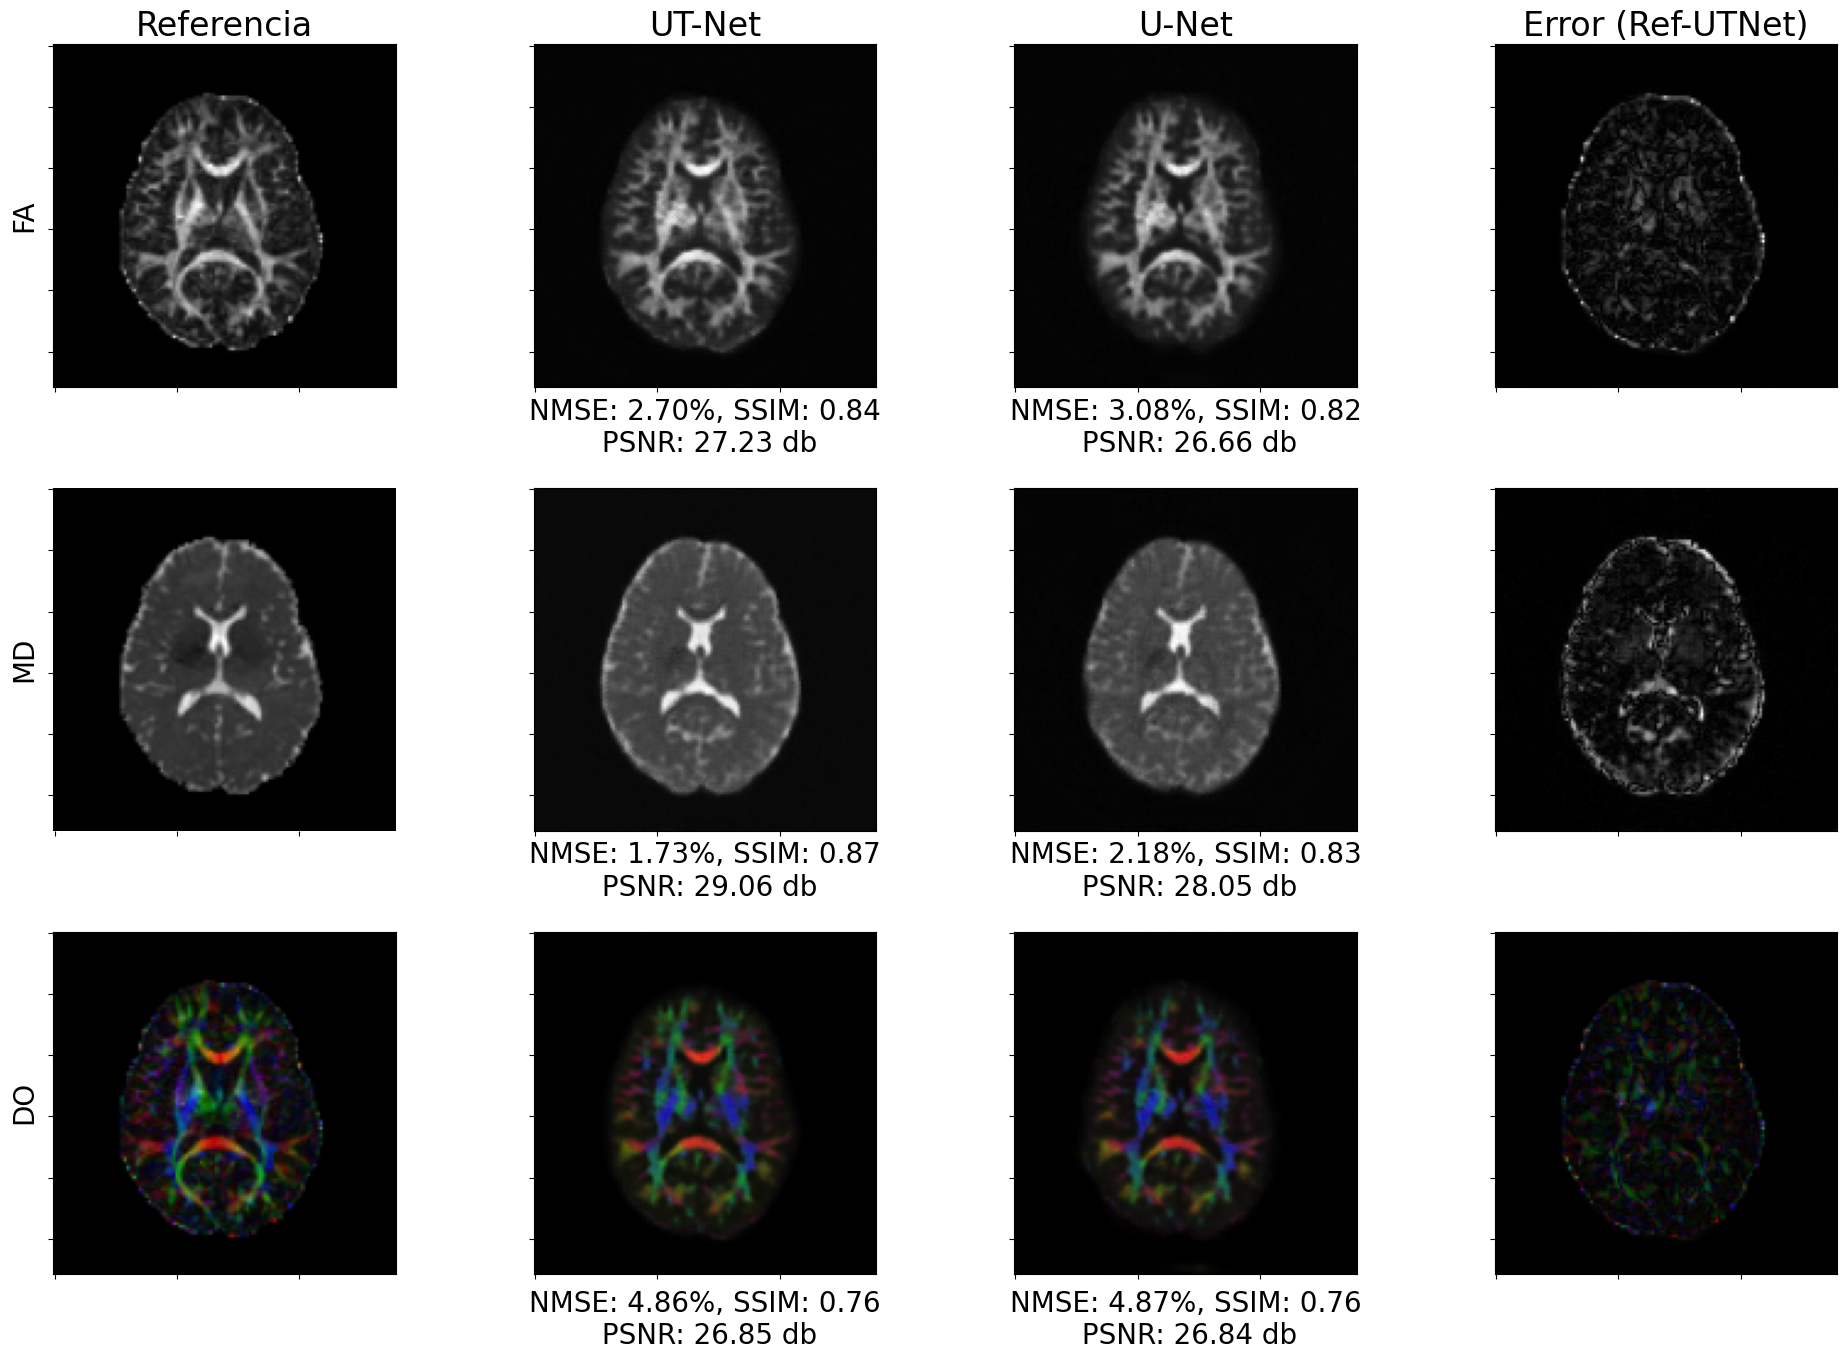

In [45]:
k_rot = 1
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 14),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(np.rot90(label_fa, k=k_rot), cmap=plt.cm.gray)
ax[0].set_xlabel(f'')
ax[0].set_title('Referencia')
ax[0].set_ylabel("FA")
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

ax[1].imshow(np.rot90(output_model_fa, k=k_rot), cmap=plt.cm.gray)
ax[1].set_xlabel(f'NMSE: {nmse_fa:.2f}%, SSIM: {ssim_v_fa:.2f}\n PSNR: {psnr_fa:.2f} db')
ax[1].set_title('UT-Net')
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

ax[2].imshow(np.rot90(output_unet_fa, k=k_rot), cmap=plt.cm.gray)
ax[2].set_xlabel(f'NMSE: {nmse_unet_fa:.2f}%, SSIM: {ssim_v_unet_fa:.2f}\n PSNR: {psnr_unet_fa:.2f} db')
ax[2].set_title('U-Net')
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

ax[3].imshow(np.rot90(error_fa, k=k_rot), cmap=plt.cm.gray)
#ax[3].set_xlabel(f'NMSE: {nmse_fsl:.2f}%, SSIM: {ssim_v_fsl:.2f}\n PSNR: {psnr_fsl:.2f} db')
ax[3].set_title('Error (Ref-UTNet)')
ax[3].set_yticklabels([])
ax[3].set_xticklabels([])


ax[4].imshow(np.rot90(label_md, k=k_rot), cmap=plt.cm.gray)
ax[4].set_xlabel(f'')
ax[4].set_ylabel("MD")
ax[4].set_yticklabels([])
ax[4].set_xticklabels([])

ax[5].imshow(np.rot90(output_model_md, k=k_rot), cmap=plt.cm.gray)
ax[5].set_xlabel(f'NMSE: {nmse_md:.2f}%, SSIM: {ssim_v_md:.2f}\n PSNR: {psnr_md:.2f} db')
ax[5].set_yticklabels([])
ax[5].set_xticklabels([])

ax[6].imshow(np.rot90(output_unet_md, k=k_rot), cmap=plt.cm.gray)
ax[6].set_xlabel(f'NMSE: {nmse_unet_md:.2f}%, SSIM: {ssim_v_unet_md:.2f}\n PSNR: {psnr_unet_md:.2f} db')
ax[6].set_yticklabels([])
ax[6].set_xticklabels([])

ax[7].imshow(np.rot90(error_md, k=k_rot), cmap=plt.cm.gray)
ax[7].set_yticklabels([])
ax[7].set_xticklabels([])



ax[8].imshow(np.rot90(label_rgb.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[8].set_xlabel(f'')
ax[8].set_ylabel("DO")
ax[8].set_yticklabels([])
ax[8].set_xticklabels([])

ax[9].imshow(np.rot90(output_model_rgb.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[9].set_xlabel(f'NMSE: {nmse_rgb:.2f}%, SSIM: {ssim_v_rgb:.2f}\n PSNR: {psnr_rgb:.2f} db')
ax[9].set_yticklabels([])
ax[9].set_xticklabels([])

ax[10].imshow(np.rot90(output_unet_rgb.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[10].set_xlabel(f'NMSE: {nmse_unet_rgb:.2f}%, SSIM: {ssim_v_unet_rgb:.2f}\n PSNR: {psnr_unet_rgb:.2f} db')
ax[10].set_yticklabels([])
ax[10].set_xticklabels([])

ax[11].imshow(np.rot90(error_rgb.transpose(1,2,0), k=k_rot), cmap=plt.cm.gray)
ax[11].set_yticklabels([])
ax[11].set_xticklabels([])


ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].spines['bottom'].set_visible(False)
ax[4].spines['left'].set_visible(False)



plt.tight_layout()
plt.savefig(results_path+f"/robustness_result_{case_num}_{slice_idx}.png")
plt.show()

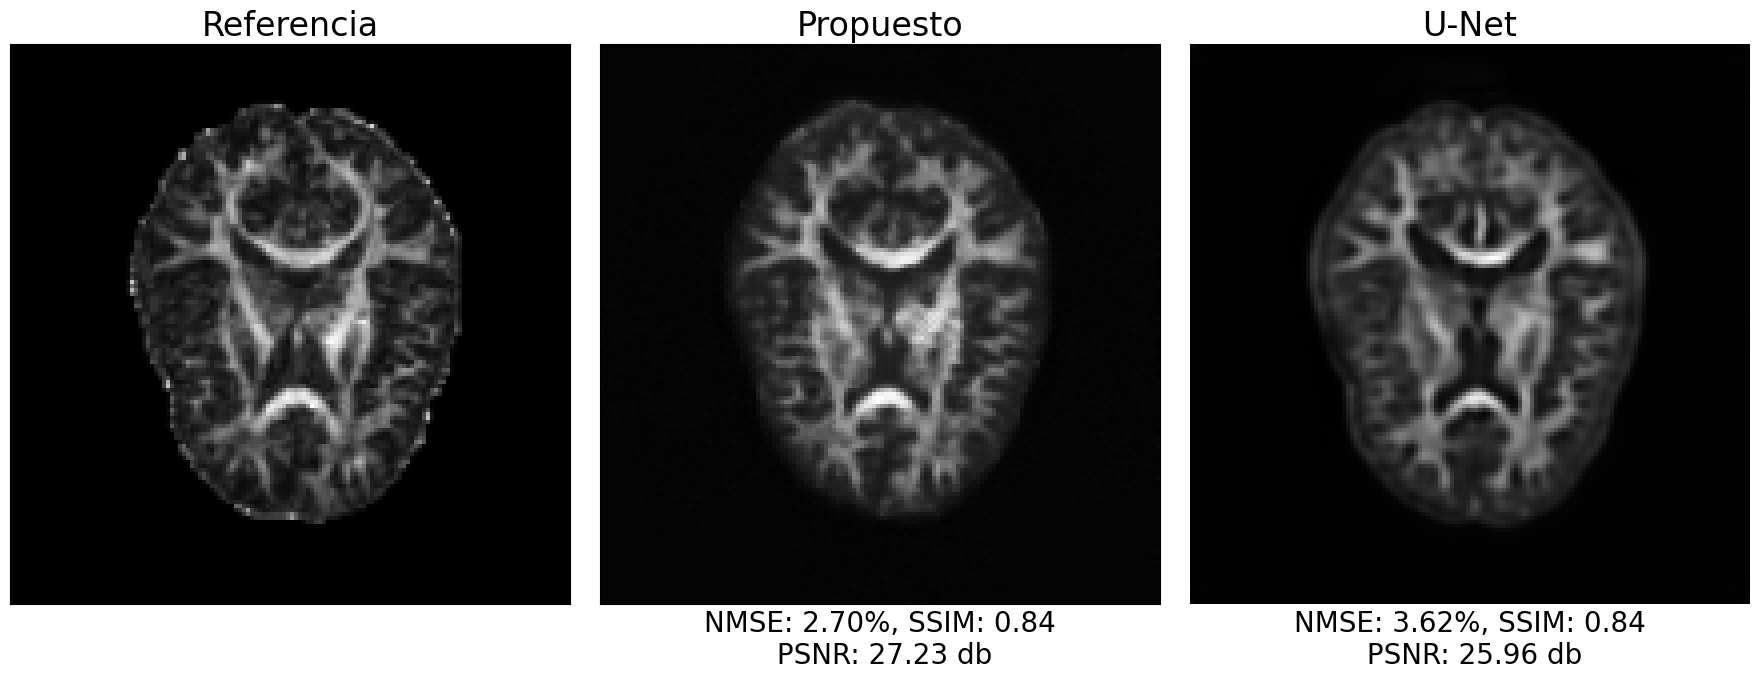

In [ ]:
k_rot = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(np.rot90(label_np, k=k_rot), cmap=plt.cm.gray) #transpose(1,2,0)
ax[0].set_xlabel(f'')
ax[0].set_title('Referencia')
ax[0].set_ylabel("")
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

ax[1].imshow(np.rot90(output_model, k=k_rot), cmap=plt.cm.gray)
ax[1].set_xlabel(f'NMSE: {nmse:.2f}%, SSIM: {ssim_v:.2f}\n PSNR: {psnr:.2f} db')
ax[1].set_title('Propuesto')
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

ax[2].imshow(np.rot90(output_unet, k=k_rot), cmap=plt.cm.gray)
ax[2].set_xlabel(f'NMSE: {nmse_unet:.2f}%, SSIM: {ssim_v_unet:.2f}\n PSNR: {psnr_unet:.2f} db')
ax[2].set_title('U-Net')
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

# Hide axes ticks
ax[2].set_xticks([])
ax[2].set_yticks([])
#fig.colorbar(ax_bar, ax=[ax[4]], location='left', aspect=6)
#fig.colorbar(ax_bar, ax=[ax[4]], location='left', aspect=5, pad=.8)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(results_path+f"/fa_result_{case_num}_{slice_idx}.png")
plt.show()